In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#fbbc04', '#199de5', '#cfe6d5']

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# FEMALE

### Read in dataset

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [4]:
adata = sc.read(path_to_gonads + 'FCA-gonads_female_annotated.h5ad')

In [5]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


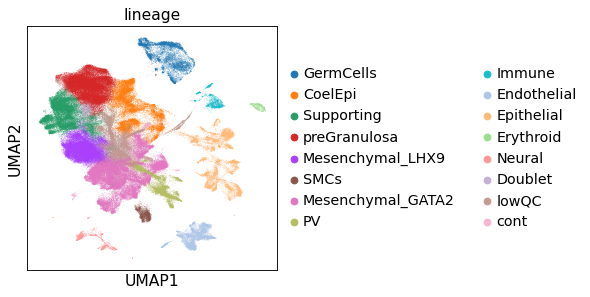

In [6]:
sc.pl.umap(adata, color=['lineage'])
adata.obs['lineage'].cat.reorder_categories(['GermCells', 'CoelEpi', 'Supporting', 'preGranulosa', 'Mesenchymal_LHX9',
                                              'Mesenchymal_GATA2', 'PV', 'SMCs',
                                              'Immune',  'Endothelial', 
                                              'Epithelial', 
                                                'Erythroid', 'Neural', 'lowQC', 'Doublet', 'cont'], inplace=True)

In [7]:
X = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
X = X[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_LHX9', 'Supporting', 'Sertoli', 'Ti', 'FetalLeydig', 'late_sPAX8', 'preGranulosa', 'CoelEpi'] for i in X.obs.lineageSomatic]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
print('Total number of cells: {:d}'.format(X.n_obs))
print('Total number of genes: {:d}'.format(X.n_vars))
X.obs['donor'].values.describe()

Total number of cells: 213898
Total number of genes: 28266


,counts,freqs
categories,,
F81,8628,0.040337
F83,10557,0.049355
F84,2854,0.013343
F86,3301,0.015433
F87,2477,0.011580
F89,1485,0.006943
F91,4638,0.021683
F96,1760,0.008228
F99,6267,0.029299


In [9]:
colorsGen_df = pd.read_csv('gonads_general_colors.csv',index_col=0)
colorsGen_df

colorsSom_df = pd.read_csv('gonads_somatic_colors.csv',index_col=0)
colorsSom_df

colors_df = colorsGen_df.append(colorsSom_df, ignore_index=False).drop_duplicates()

idx = [colors_df.index.tolist().index(i) for i in adata.obs['lineage'].cat.categories.tolist() ]
X.uns['lineage_colors'] = [ colors_df.color[i] for i in idx ]

idx = [colors_df.index.tolist().index(i) for i in X.obs['lineageSomatic'].cat.categories.tolist() ]
X.uns['lineageSomatic_colors'] = [ colors_df.color[i] for i in idx ]

label_annot = colors_df['label'].to_dict()
X.obs['labels'] = X.obs['lineageSomatic'].map(label_annot)

colors_df = colors_df.set_index('label')
label2color_annot = colors_df['color'].to_dict()
from natsort import natsorted
x = natsorted(list(set(X.obs['labels'])))
X.uns['labels_colors'] = [ label2color_annot[i] for i in  x ]

Trying to set attribute `.uns` of view, copying.


... storing 'labels' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


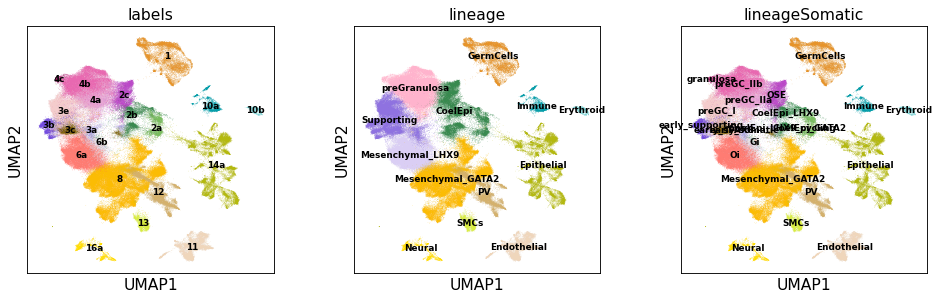

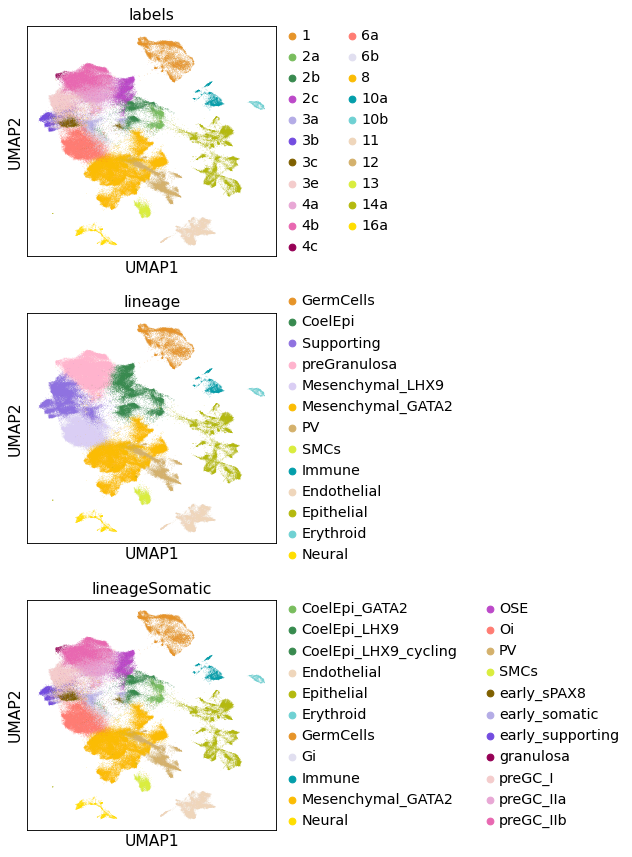

In [10]:
# plt.rcParams['figure.figsize'] = (4,4)
sc.pl.umap(X, color=['labels', 'lineage', 'lineageSomatic'], legend_loc='on data', legend_fontsize=8, save='_human_female_labelsON.pdf')


with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(X, color=['labels', 'lineage', 'lineageSomatic'], ncols=1, save='_human_female_legend.pdf')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'location' as categorical
... storing 'stage' as categorical
... storing 'batch_collection' as categorical
... storing 'enrichment' as categorical
... storing 'cryopreserved' as categorical
... storing 'TP' as categorical
... storing '10xKit' as categorical
... storing 'dig_protocol' as categorical
... storing 'lineages_v1' as categorical
... storing 'celltype_v1' as categorical
... storing 'lineage_v2' as categorical
... storing 'somatic_celltype_v2' as categorical
... storing 'sample_source' as categorical
... storing 'leiden' as categorical
... storing 'leiden_R' as categorical
... storing 'lineage' as categorical
... storing 

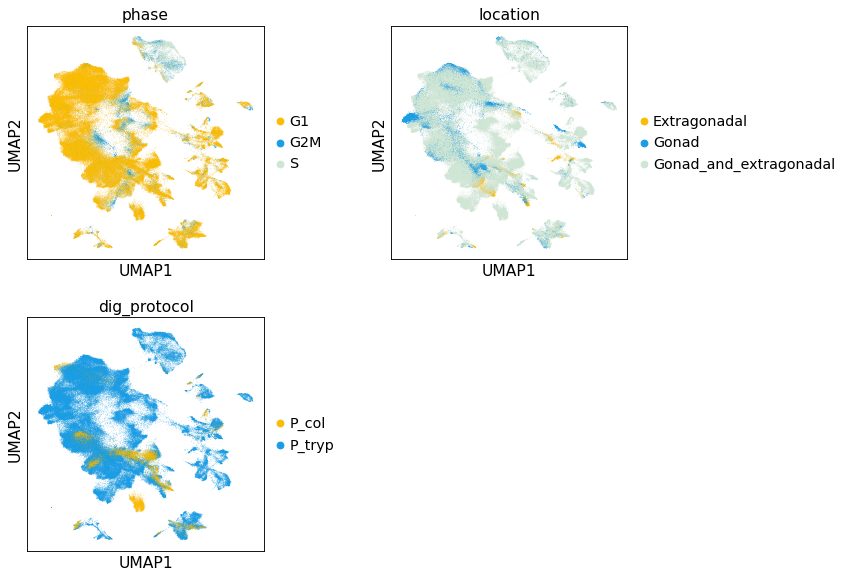

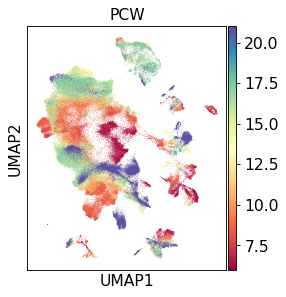

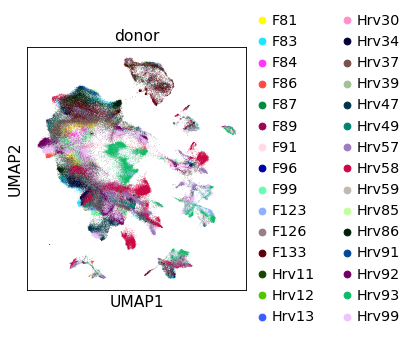

In [11]:
X_last = X[[ i in 'Gonad_and_extragonadal' for i in X.obs.location ]]
X_first = X[[ 'Gonad_and_extragonadal' not in i for i in X.obs.location ]]
X_resorted = X_first.concatenate(X_last)

with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X_resorted,
    color=['phase', 'location',  'dig_protocol'], palette=palette,
    frameon=True, ncols = 2, wspace = 0.4, save='_female_metadata_I.pdf'
)
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
        X,
        color=["PCW"], cmap='Spectral',
        frameon=True, ncols = 2, wspace = 0.3, save='_female_metadata_II.pdf'
    )
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
        X,
        color=["donor"],
        frameon=True, ncols = 2, wspace = 0.3, save='_female_metadata_III.pdf'
    )

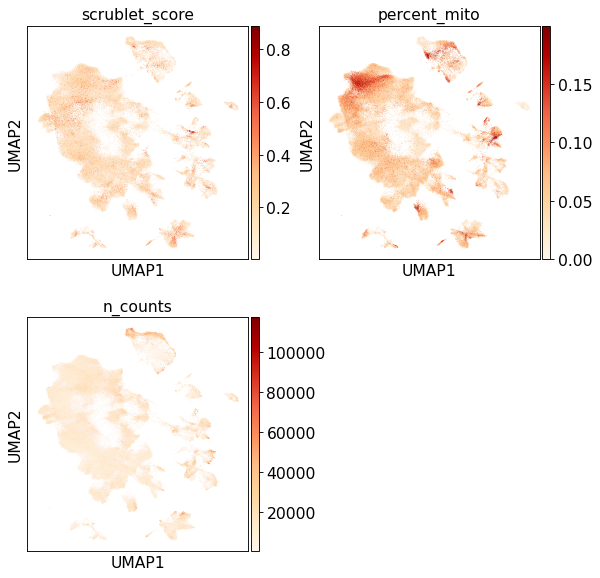

In [12]:
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X,
    color=['scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.2, save='_female_metadata_III.pdf'
)


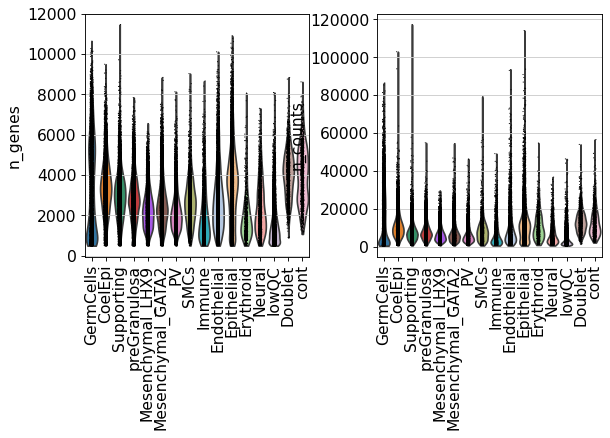

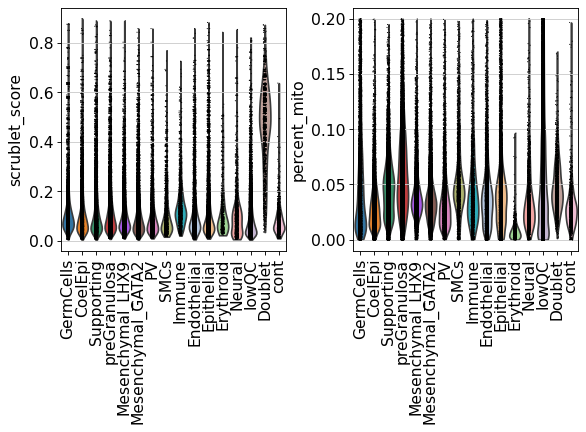

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='lineage', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='lineage', rotation=90)

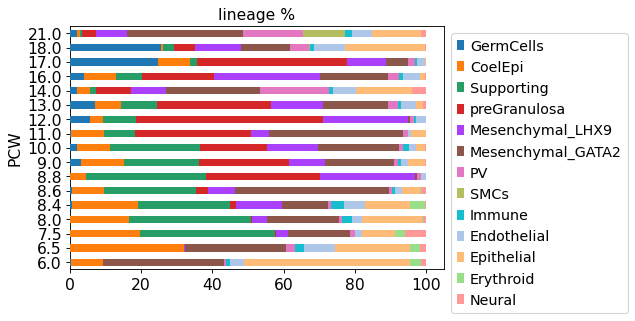

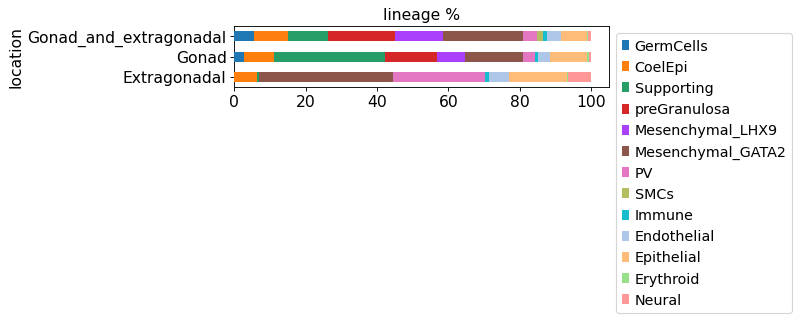

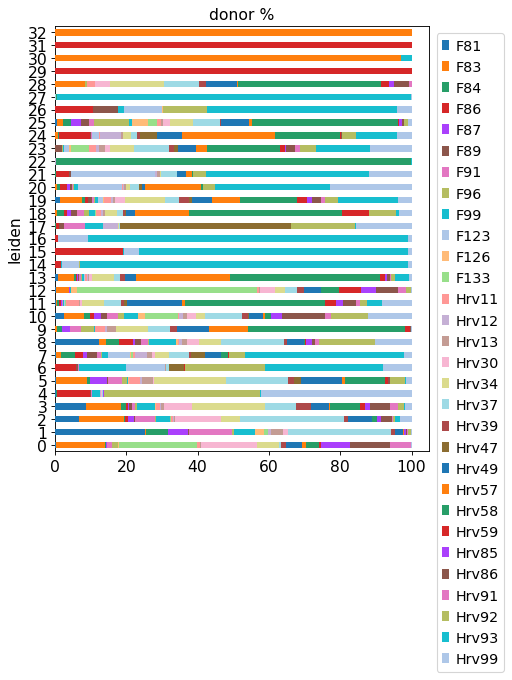

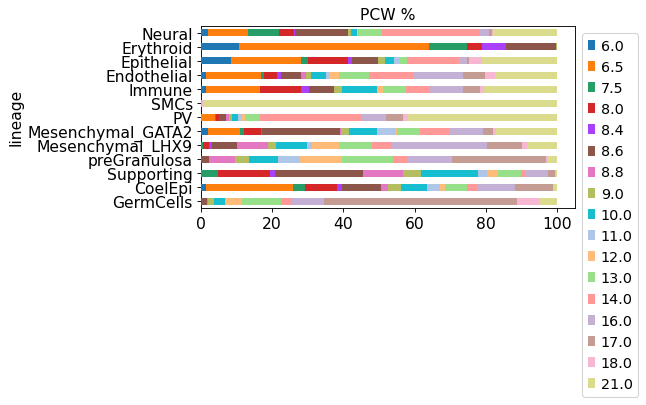

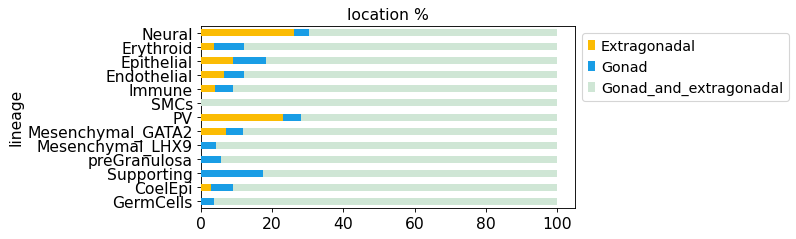

In [25]:
Barplot('lineage', X, var='PCW', height=4)
Barplot('lineage', X, var='location', height=1)
Barplot('donor', adata, var='leiden', height=7)
Barplot('PCW', X, var='lineage', height=3)
Barplot('location', X, var='lineage', height=3, color=palette)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


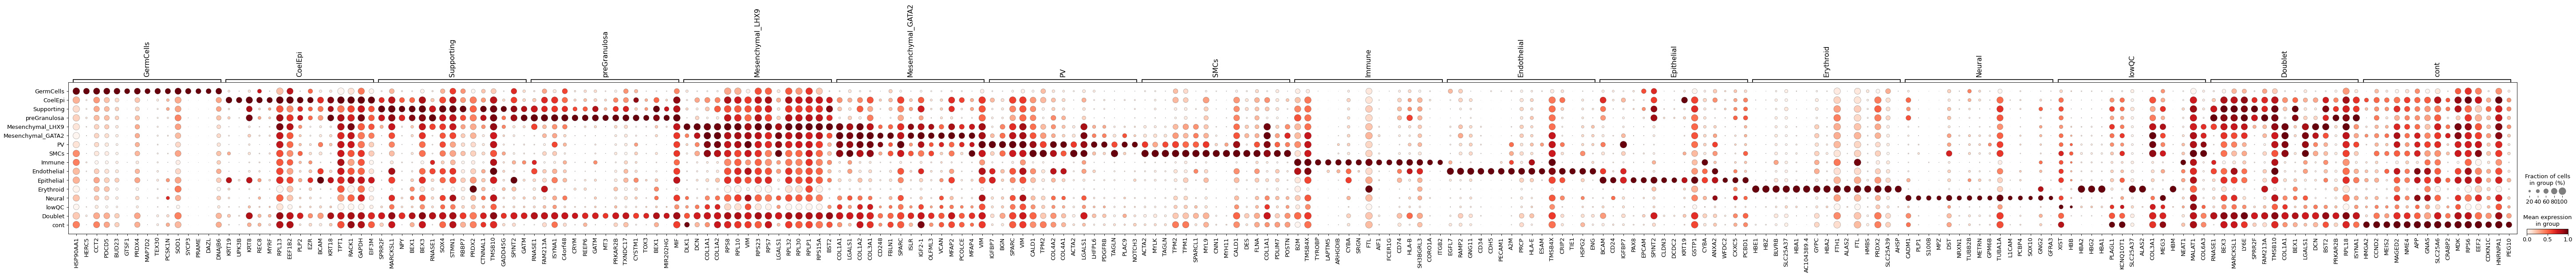

In [15]:
sc.tl.rank_genes_groups(adata, groupby='lineage', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

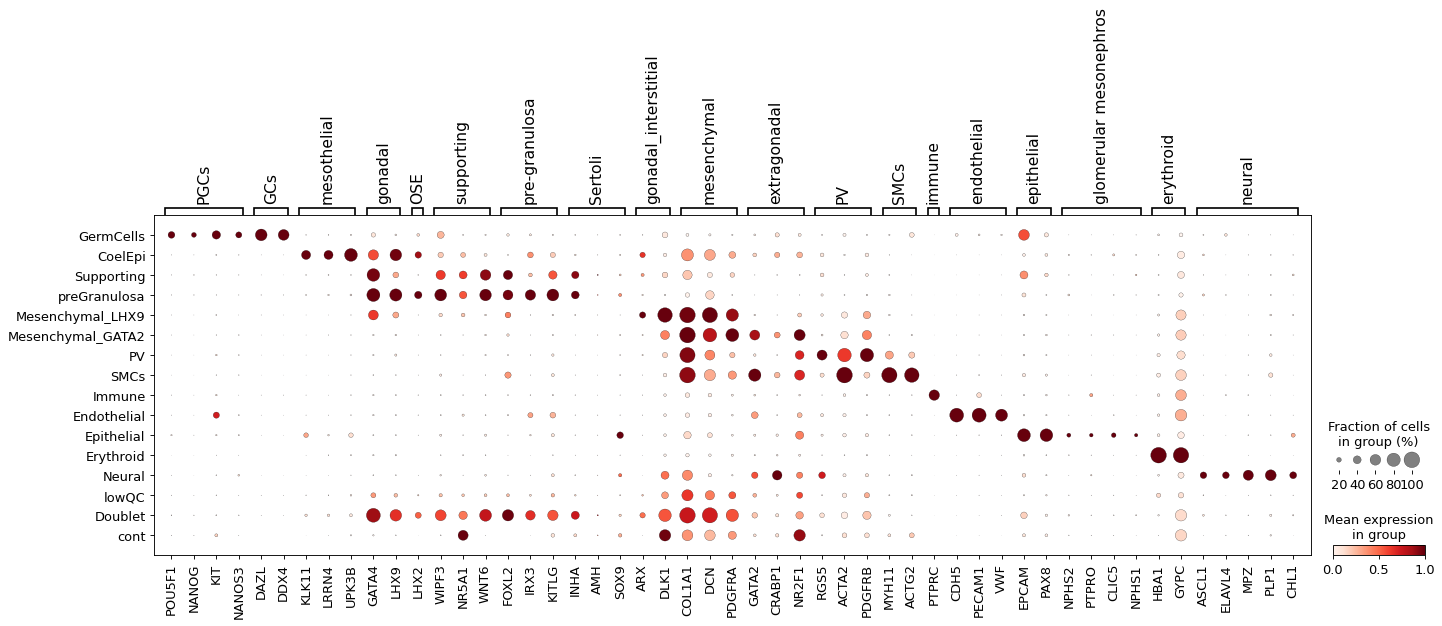

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


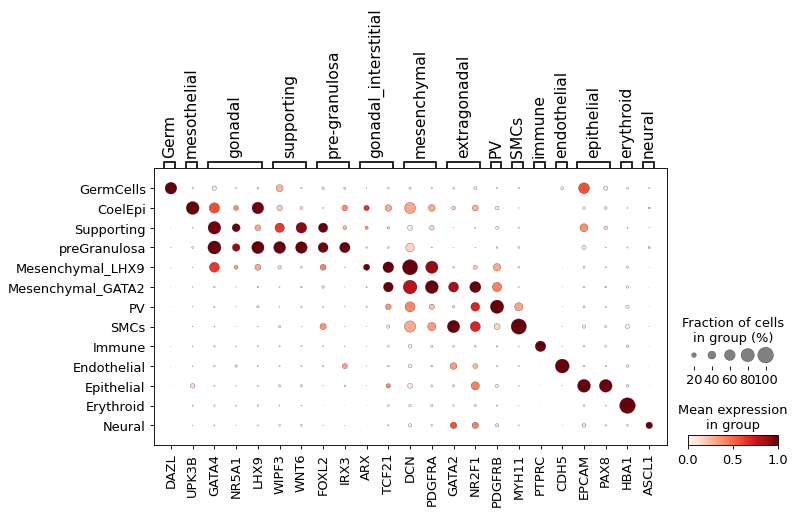

In [38]:
marker_genes = {
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'GCs': {'DAZL', 'DDX4'}, 
    'mesothelial': {'UPK3B', "LRRN4", 'KLK11'},
    'gonadal':{'GATA4', 'LHX9'},
    'OSE': {'LHX2'},
    'supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'pre-granulosa':{"KITLG", 'FOXL2', 'IRX3'},
#     'Granulosa':{'RDH10'},
    'Sertoli': {'SOX9', 'AMH', 'INHA'},
    'gonadal_interstitial':{ 'ARX', 'DLK1'},
    'mesenchymal':{'DCN', 'PDGFRA', 'COL1A1'},
    'extragonadal':{'GATA2', 'NR2F1', 'CRABP1'},
    'PV': {"PDGFRB", 'ACTA2', 'RGS5'},
    'SMCs':{'ACTG2', 'MYH11'},
    'immune': {'PTPRC'},
    'endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'epithelial': {"EPCAM", 'PAX8'},
    'glomerular mesonephros': {'NPHS1',"NPHS2", "CLIC5", "PTPRO"},
    'erythroid': {"GYPC", "HBA1"},
    'neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'}
}
marker_genes_short = {
    'Germ': {'DAZL'}, 
    'mesothelial': {'UPK3B'},
    'gonadal':{'GATA4', 'LHX9', 'NR5A1'},
    'supporting':{'WNT6'}, # WNT6, WIPF3, MIR202HG are new
    'pre-granulosa':{'FOXL2', 'IRX3'},
#     'Sertoli': {'SOX9', 'AMH'},
    'gonadal_interstitial':{ 'ARX', 'TCF21'},
    'mesenchymal':{'DCN', 'PDGFRA'},
    'extragonadal':{'GATA2', 'NR2F1'},
    'PV': {"PDGFRB"},
    'SMCs':{'MYH11'},
    'immune': {'PTPRC'},
    'endothelial': {'CDH5'},
    'epithelial': {"EPCAM", 'PAX8'},
    'erythroid': {"HBA1"},
    'neural': {'ASCL1'}
}
sc.pl.dotplot(adata, marker_genes_short, groupby='lineage', use_raw=False, standard_scale = 'var')
sc.pl.dotplot(adata[[i not in ['cont', 'Doublet', 'lowQC'] for i in adata.obs.lineage]], marker_genes_short, groupby='lineage', use_raw=False, standard_scale = 'var', save='female_markers.pdf')

In [17]:
print('Total number of somatic cells: {:d}'.format(X[[i not in 'GermCells' for i in X.obs.lineage]].n_obs))

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Total number of somatic cells: 203006


# PLOT Li et al scmap label tranfer

In [18]:
# Add old cluster subname
metaF = pd.read_csv('/nfs/team292/lg18/with_valentina/Li2017pred_females.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annotF = metaF['scmap_labels'].to_dict()
X.obs['scmap_labels'] = X.obs_names.map(cell_annotF).astype('category')

Trying to set attribute `.uns` of view, copying.


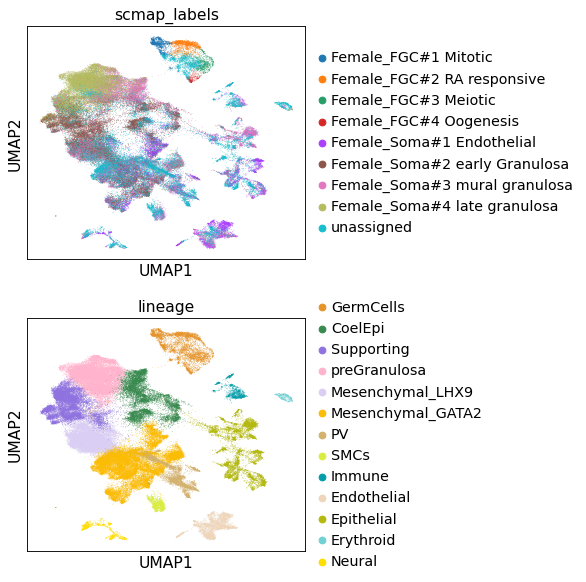

In [19]:
x = X[[ not pd.isna(i) for i in X.obs.scmap_labels]]
x.uns['lineage_colors'] = X.uns['lineage_colors']
sc.pl.umap(x, color=['scmap_labels', 'lineage'], ncols=1)

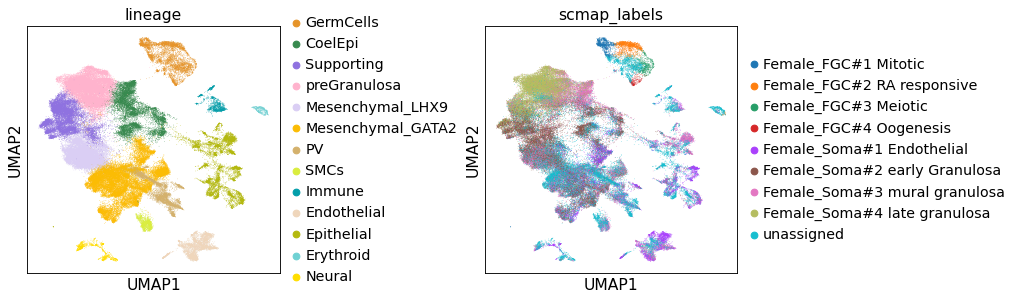

In [20]:
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    x,
    color=['lineage', 'scmap_labels'], 
    frameon=True, ncols = 2, wspace = 0.65, save='_female_Li2017annotations.pdf'
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


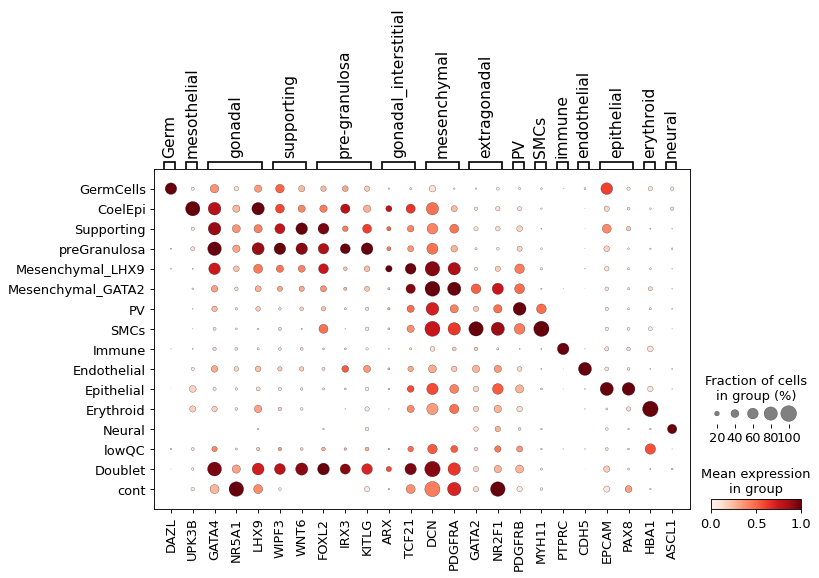

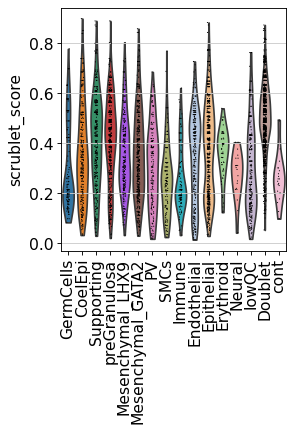

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


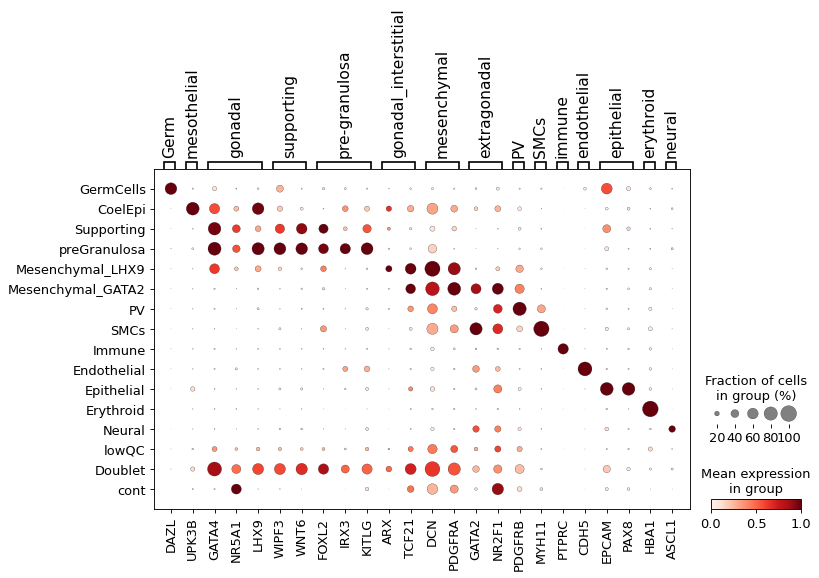

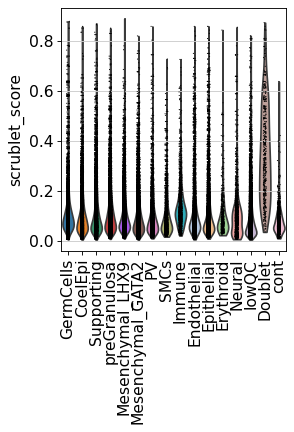

In [41]:
marker_genes = {
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'GCs': {'DAZL', 'DDX4'}, 
    'mesothelial': {'UPK3B', "LRRN4", 'KLK11'},
    'gonadal':{'GATA4', 'LHX9'},
    'OSE': {'LHX2'},
    'supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'pre-granulosa':{"KITLG", 'FOXL2', 'IRX3'},
#     'Granulosa':{'RDH10'},
    'Sertoli': {'SOX9', 'AMH', 'INHA'},
    'gonadal_interstitial':{ 'ARX', 'DLK1'},
    'mesenchymal':{'DCN', 'PDGFRA', 'COL1A1'},
    'extragonadal':{'GATA2', 'NR2F1', 'CRABP1'},
    'PV': {"PDGFRB", 'ACTA2', 'RGS5'},
    'SMCs':{'ACTG2', 'MYH11'},
    'immune': {'PTPRC'},
    'endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'epithelial': {"EPCAM", 'PAX8'},
    'glomerular mesonephros': {'NPHS1',"NPHS2", "CLIC5", "PTPRO"},
    'erythroid': {"GYPC", "HBA1"},
    'neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'}
}
marker_genes_short = {
    'Germ': {'DAZL'}, 
    'mesothelial': {'UPK3B'},
    'gonadal':{'GATA4', 'LHX9', 'NR5A1'},
    'supporting':{'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'pre-granulosa':{"KITLG", 'FOXL2', 'IRX3'},
#     'Sertoli': {'SOX9', 'AMH'},
    'gonadal_interstitial':{ 'ARX', 'TCF21'},
    'mesenchymal':{'DCN', 'PDGFRA'},
    'extragonadal':{'GATA2', 'NR2F1'},
    'PV': {"PDGFRB"},
    'SMCs':{'MYH11'},
    'immune': {'PTPRC'},
    'endothelial': {'CDH5'},
    'epithelial': {"EPCAM", 'PAX8'},
    'erythroid': {"HBA1"},
    'neural': {'ASCL1'}
}

a = adata[[i for i in adata.obs.is_doublet ]]
sc.pl.dotplot(a , marker_genes_short, groupby='lineage', use_raw=False, standard_scale = 'var')
sc.pl.violin(a, ['scrublet_score'], groupby='lineage', rotation=90)

b = adata[[not i  for i in adata.obs.is_doublet ]]
sc.pl.dotplot(b , marker_genes_short, groupby='lineage', use_raw=False, standard_scale = 'var')
sc.pl.violin(b, ['scrublet_score'], groupby='lineage', rotation=90)




In [35]:
a.obs['lineage'].values.describe()

,counts,freqs
categories,,
GermCells,129,0.027482
CoelEpi,272,0.057946
Supporting,315,0.067107
preGranulosa,444,0.094589
Mesenchymal_LHX9,235,0.050064
Mesenchymal_GATA2,398,0.084789
PV,163,0.034725
SMCs,125,0.026630
Immune,107,0.022795


In [36]:

b.obs['lineage'].values.describe()

,counts,freqs
categories,,
GermCells,10763,0.044981
CoelEpi,21139,0.088345
Supporting,27183,0.113604
preGranulosa,38437,0.160637
Mesenchymal_LHX9,27381,0.114432
Mesenchymal_GATA2,48262,0.201698
PV,10175,0.042524
SMCs,2919,0.012199
Immune,2520,0.010532
